['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y']
Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB
Any missing values?
In train:  False
In 

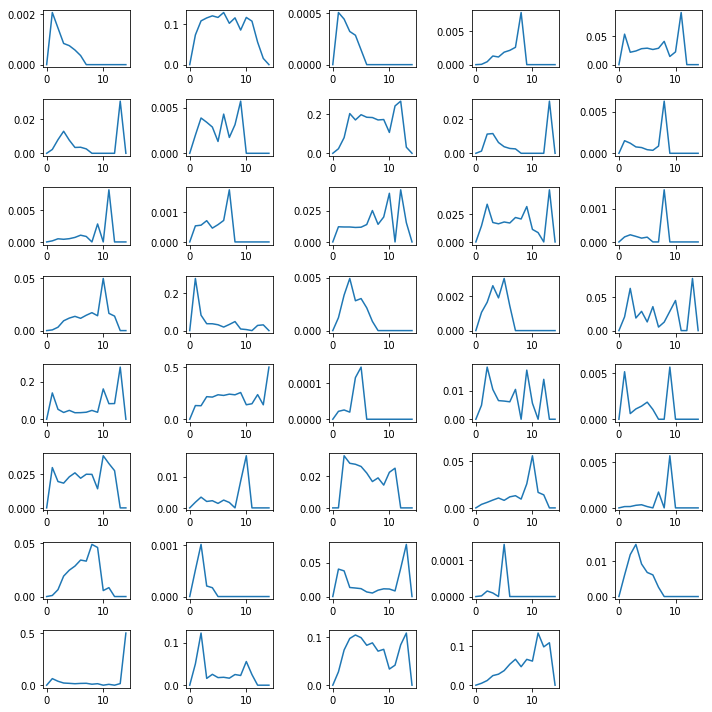

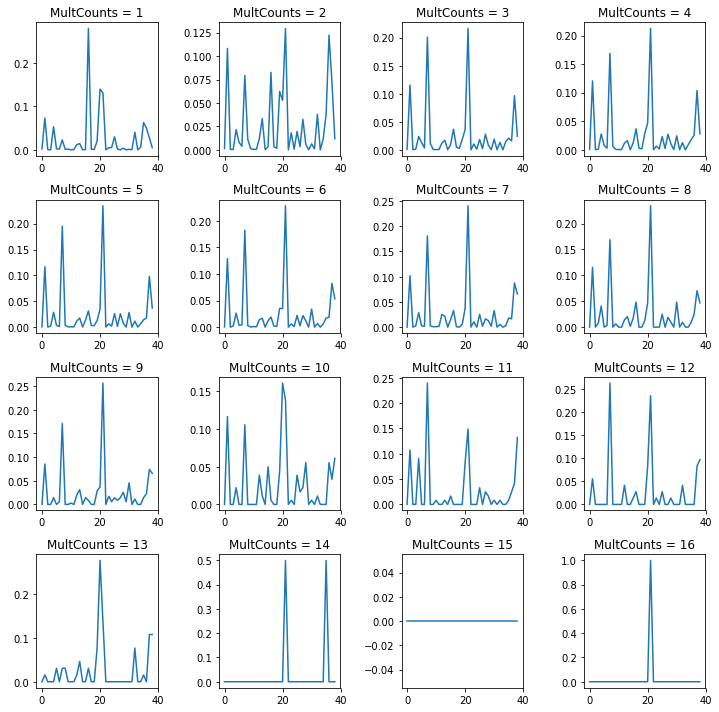

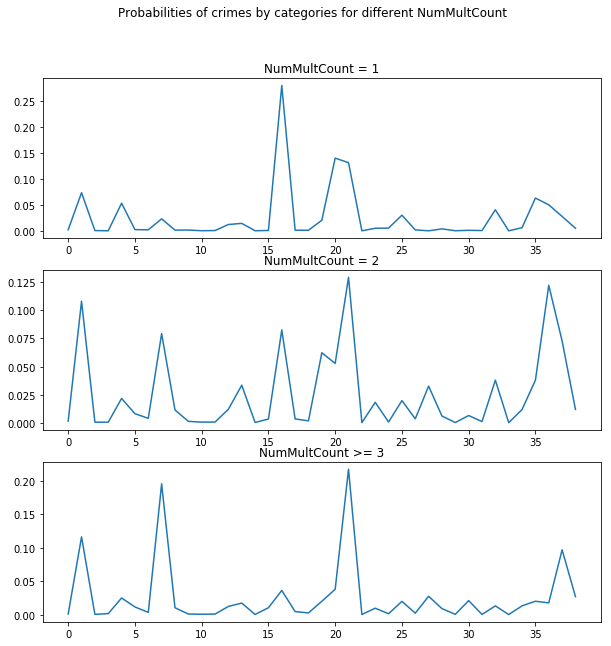

<bound method NDFrame.head of    MultProbs1  MultProbs2  MultProbs3  MultProbs4  MultProbs5  MultProbs6  \
1   -6.188288   -2.535865   -7.583242   -9.999619   -2.880017   -6.086973   
2   -6.541286   -2.109738   -7.718282   -7.741549   -3.813315   -4.817109   
3   -7.153636   -2.029493   -8.125290   -6.600402   -3.671795   -4.463808   

   MultProbs7  MultProbs8  MultProbs9  MultProbs10     ...       MultProbs30  \
1   -6.222625   -3.747536   -6.635203    -6.495606     ...         -8.848949   
2   -5.554052   -2.451799   -4.468422    -6.715363     ...         -8.817190   
3   -5.738561   -1.414788   -4.579259    -7.193276     ...         -8.099964   

   MultProbs31  MultProbs32  MultProbs33  MultProbs34  MultProbs35  \
1    -6.911269    -7.565533    -3.165125   -13.218539    -5.107502   
2    -5.047330    -6.890313    -3.235180   -11.086007    -4.432591   
3    -3.851683    -8.610911    -4.333026   -11.095985    -4.328292   

   MultProbs36  MultProbs37  MultProbs38  MultProbs39  
1  

In [11]:
'''
n Francisco

A competition hosted by kaggle:
https://www.kaggle.com/c/sf-crime

Analysis and cleaning of the data
Some feature engineering

'''


import sys
from copy import deepcopy
import numpy
import pandas
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import Holiday, HolidayCalendarFactory, FR, DateOffset
import matplotlib.pyplot
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
import pylab

data_dir = "data"

# Load Data into pandas DataFrames
train = pandas.read_csv('{}/train.csv'.format(data_dir), parse_dates=['Dates'])
test = pandas.read_csv('{}/test.csv'.format(data_dir), parse_dates=['Dates'])

# short versions for debugging
#train = train.head(1000)
#test = test.head(900)

# names of columns
print(list(train.columns.values))
print(list(test.columns.values))

# data types of columns
print(train.dtypes)

train.info()

print('Any missing values?')
print('In train: ', pandas.isnull(train).values.any())
print('In test:  ', pandas.isnull(test).values.any())

# print first ten rows of train
# print(train.head(10))

'''

Sometimes, multiple crimes occur at the same place and time.
Those are probably linked, i.e. one deed involving several
different crimes.

This will certainly be important when building models. We'll
take that into account by adding a new column with the number
of simultaneous crimes and by computing the log odds of crimes
occurring simultaneously.

count the number of times when identical dates, x, and y appear in the data
i.e. multiple crimes committed in one act

'''

print('Multiple crimes in the test data')
counts = test.groupby(['Dates', 'X', 'Y']).size()
# the counts
numMult = counts.value_counts()
print(numMult)
# largest number of simultaneous crimes in the test data
maxCrimesTest = max(counts)
# add counts to test
counts = pandas.DataFrame(counts)
counts = counts.reset_index()
test = test.merge(counts, how='right')
test.rename(columns={0:'NumMultCrimes'}, inplace=True)

print('Multiple crimes in the training data')
counts = train.groupby(['Dates', 'X', 'Y']).size()
# the counts
print(counts.value_counts())
# largest number of simultaneous crimes
maxCrimesTrain = max(counts)
# add counts to train
counts = pandas.DataFrame(counts)
counts = counts.reset_index()
train = train.merge(counts, how='right')
train.rename(columns={0:'NumMultCrimes'}, inplace=True)

# we don't need counts anymore
del counts

# sorted list of crime categories
categories=sorted(train['Category'].unique())
print(categories)

# largest number of simultaneous crimes
maxCrimes = max(maxCrimesTest, maxCrimesTrain)
print('maxCrimes ', maxCrimes)
MultCounts = numpy.zeros((maxCrimes+1, len(categories)))
MultProbs = numpy.zeros((maxCrimes+1, len(categories)))

for i in range(len(categories)):
    for j in range(maxCrimes+1):
        MultCounts[j, i] = len(train.loc[(train['Category'] == categories[i]) & (train['NumMultCrimes'] == j)].index)

for numc in range(1,maxCrimes+1):
    norm = MultCounts[numc].sum()
    for j in range(len(categories)):
        if (norm>0): MultProbs[numc, j] = MultCounts[numc, j]/norm

# plot the probabilities of crimes to occur in a multiple crime
# by the count of multiple crimes for the different categories
# of offenses
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
for i in range(39):
    ax = 'ax'+str(i)
    ax = fig1.add_subplot(8, 5, i+1)
    ax.plot(MultProbs[:15,i])
    #ax.set_title(categories[i])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# plot the probability of crimes to occur in a multiple crime
# by the crime category for the different values of MultCount <= 16
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
for i in range(16):
    ax = 'ax'+str(i)
    ax = fig1.add_subplot(4, 4, i+1)
    ax.plot(MultProbs[i+1,:])
    ax.set_title('MultCounts = '+str(i+1))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# given those plots and the scarcity of data for NumMultCount >3
# we'll only consider NumMultCount 1, 2, and >= 3 separately from
# now on

MultCountsShort = numpy.zeros((4, len(categories)))
MultProbsShort = numpy.zeros((4, len(categories)))
MultLogOdds = numpy.zeros((4, len(categories)))

MultCountsShort[1,:] = MultCounts[1,:]
MultCountsShort[2,:] = MultCounts[2,:]
MultCountsShort[3,:] = MultCounts[3,:] + \
                       MultCounts[4,:] + \
                       MultCounts[5,:] + \
                       MultCounts[6,:] + \
                       MultCounts[7,:] + \
                       MultCounts[8,:] + \
                       MultCounts[9,:] + \
                       MultCounts[10,:] + \
                       MultCounts[11,:] + \
                       MultCounts[12,:] + \
                       MultCounts[13,:] + \
                       MultCounts[14,:] + \
                       MultCounts[15,:] + \
                       MultCounts[16,:]

# compute the log odds for crimes to occur
# in a multiple crime event
for numc in range(1,4):
    norm = MultCountsShort[numc].sum()
    for j in range(len(categories)):
        if (norm>0): MultProbsShort[numc, j] = MultCountsShort[numc, j]/norm
        # replace probs by log odds
        if (MultProbsShort[numc, j] == 0):
            MultLogOdds[numc, j] = -34.5  # p = 1e-15
        elif (MultProbsShort[numc, j] == 1):
            MultLogOdds[numc, j] = 34.5  # p = 1-1e-15
        else:
            MultLogOdds[numc, j] = numpy.log(MultProbsShort[numc, j]) - numpy.log(1 - MultProbsShort[numc, j])

# plot the condensed probability of crimes to occur in a multiple crime
# by the crime category for MultCount = 1, 2, and 3 or larger
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
ax0 = fig1.add_subplot(3, 1, 1)
ax1 = fig1.add_subplot(3, 1, 2)
ax2 = fig1.add_subplot(3, 1, 3)
ax0.plot(MultProbsShort[1,:])
ax1.plot(MultProbsShort[2,:])
ax2.plot(MultProbsShort[3,:])
ax0.set_title('NumMultCount = 1')
ax1.set_title('NumMultCount = 2')
ax2.set_title('NumMultCount >= 3')
fig1.suptitle('Probabilities of crimes by categories for different NumMultCount')
matplotlib.pyplot.show()

# replace all values of NumMultCount > 3 by 3
train.loc[train['NumMultCrimes'] > 3, 'NumMultCrimes'] = 3
test.loc[test['NumMultCrimes'] > 3, 'NumMultCrimes'] = 3
# and turn them into factor levels
train['NumMultCrimes'] = train['NumMultCrimes'].astype('category')
test['NumMultCrimes'] = test['NumMultCrimes'].astype('category')

# convert the log odds into a proper DataFrame
MultLogOdds = pandas.DataFrame(MultLogOdds)
# add a column name
MultLogOdds.columns=["MultProbs"+str(x+1) for x in range(len(MultLogOdds.columns))]
# drop row 0
MultLogOdds = MultLogOdds[1:]
print(MultLogOdds.head)
MultLogOdds.insert(0, 'NumMultCrimes', list(range(1,4)))
# add the log odds to train and test
# train = pandas.concat(train, MultLogOdds,join='left')
train = train.merge(MultLogOdds, how='left')
# test = pandas.concat(test, MultLogOdds,join='left')
test = test.merge(MultLogOdds, how='left')


In [4]:
# train = pandas.concat([train, MultLogOdds],join='left')
train = train.merge(MultLogOdds, how='left')
#test = pandas.concat(test, MultLogOdds,join='left')
# test = test.merge(MultLogOdds, how='left')


In [7]:
#train

Any missing values?
In train:  False
In test:   False
365
1
Any data for February 29?
Empty DataFrame
Columns: [Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y, NumMultCrimes, MultProbs1, MultProbs2, MultProbs3, MultProbs4, MultProbs5, MultProbs6, MultProbs7, MultProbs8, MultProbs9, MultProbs10, MultProbs11, MultProbs12, MultProbs13, MultProbs14, MultProbs15, MultProbs16, MultProbs17, MultProbs18, MultProbs19, MultProbs20, MultProbs21, MultProbs22, MultProbs23, MultProbs24, MultProbs25, MultProbs26, MultProbs27, MultProbs28, MultProbs29, MultProbs30, MultProbs31, MultProbs32, MultProbs33, MultProbs34, MultProbs35, MultProbs36, MultProbs37, MultProbs38, MultProbs39, Date, Year, Month, Day, DayOfYear, Time, Hour, Minutes]
Index: []

[0 rows x 56 columns]


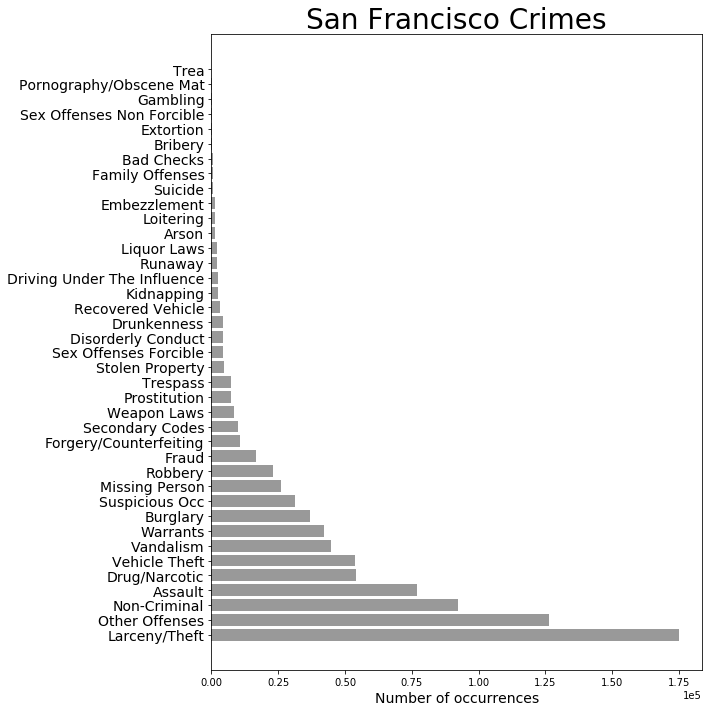

San Francisco Crimes

Category		Number of occurrences
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2

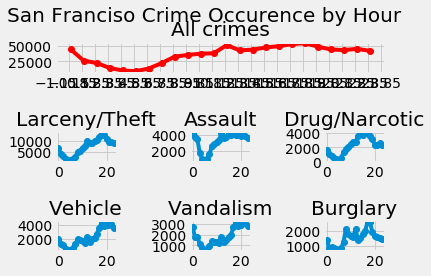

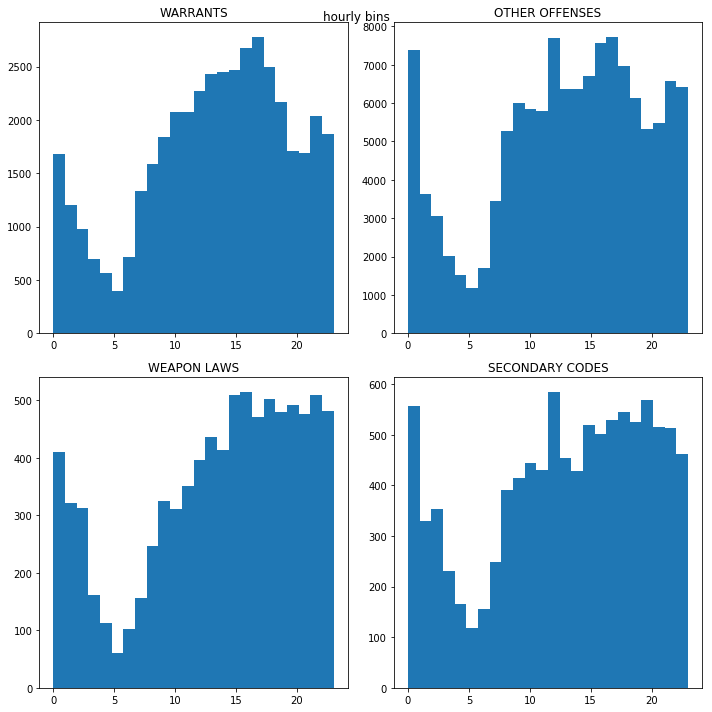

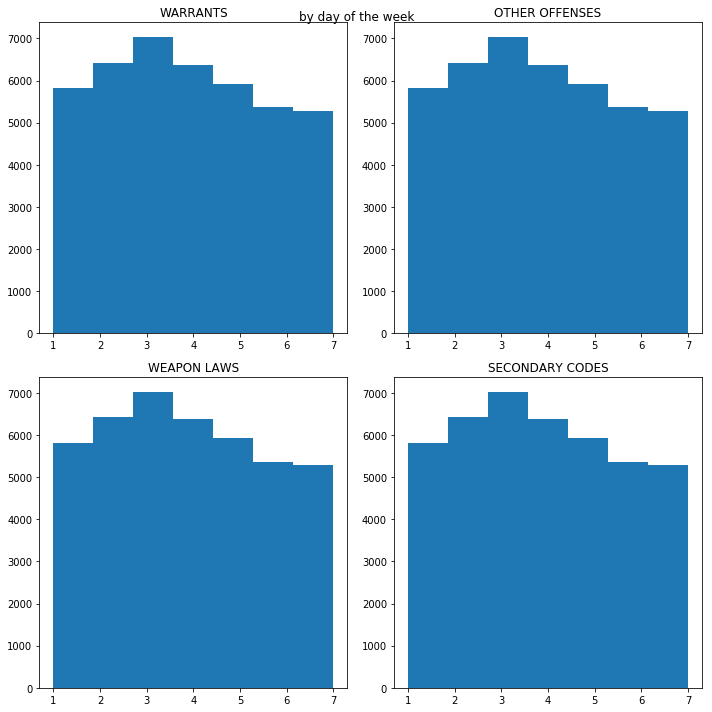

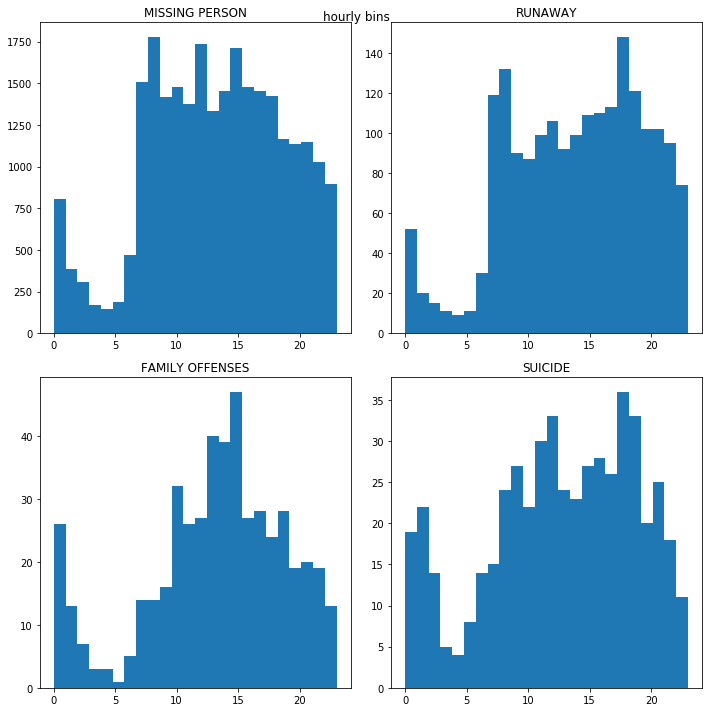

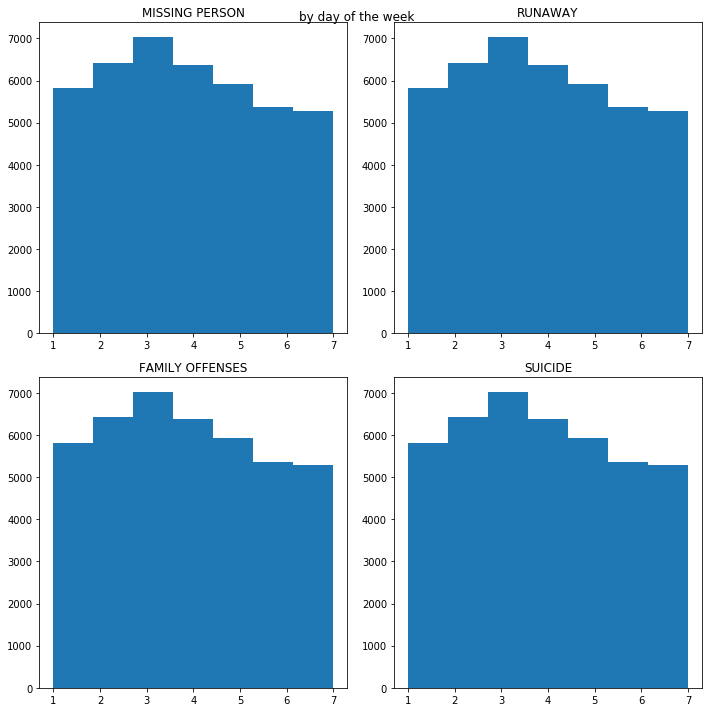

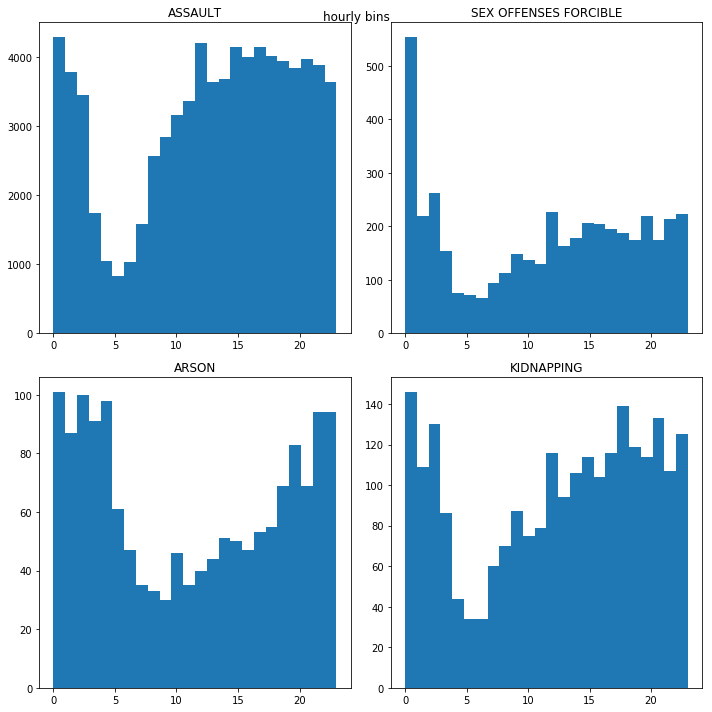

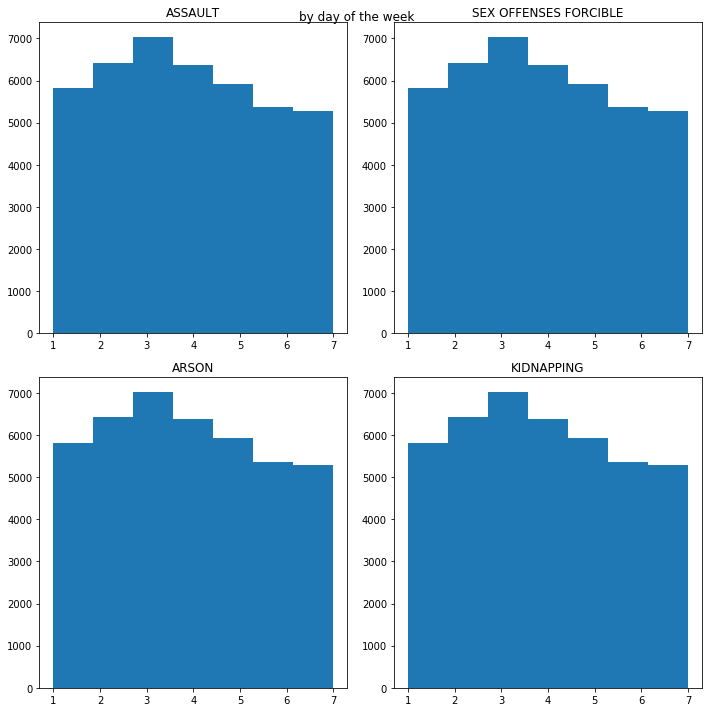

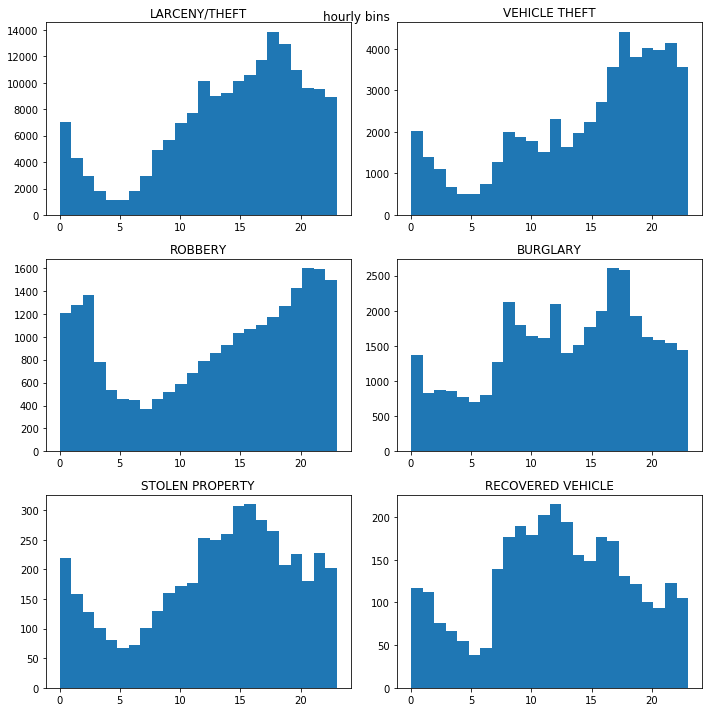

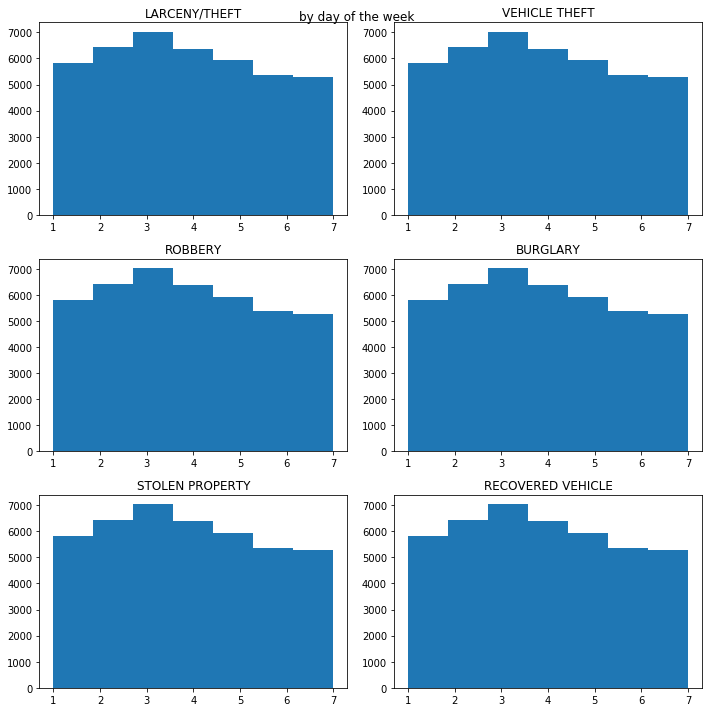

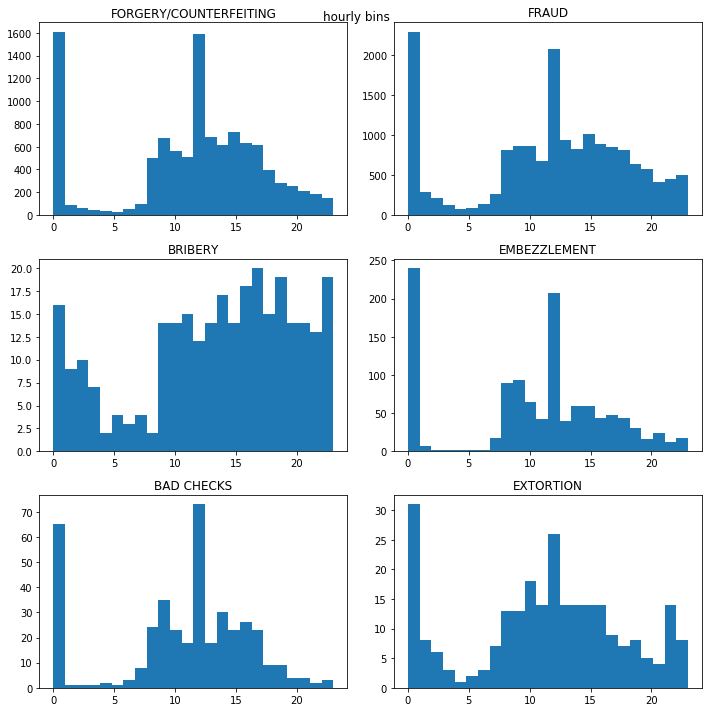

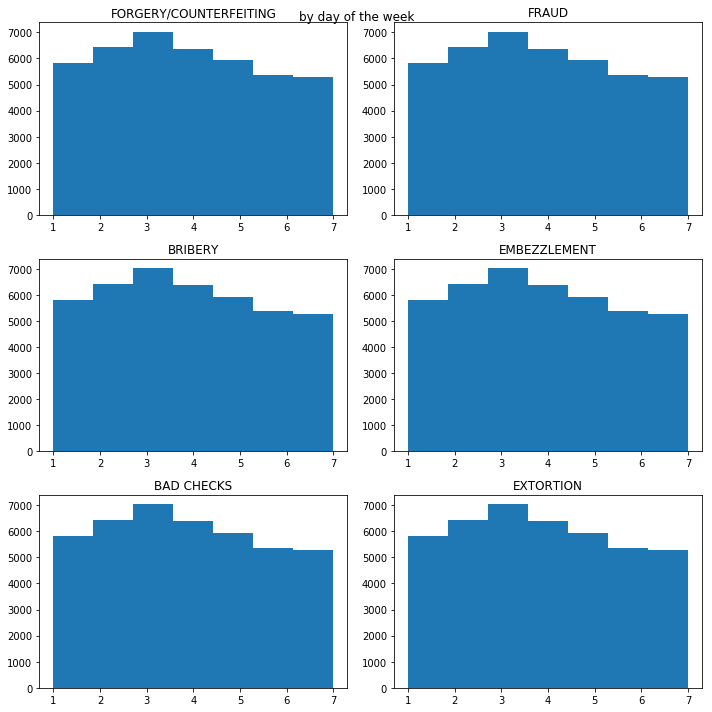

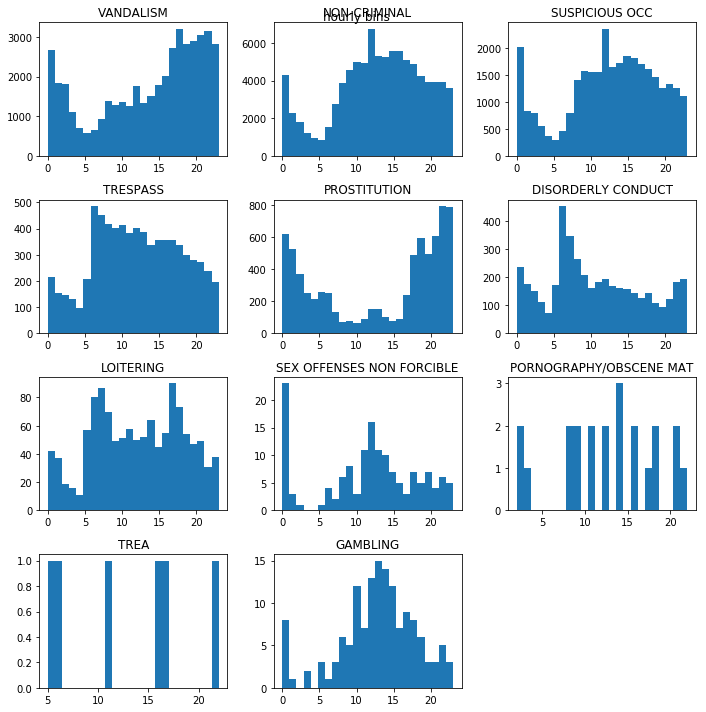

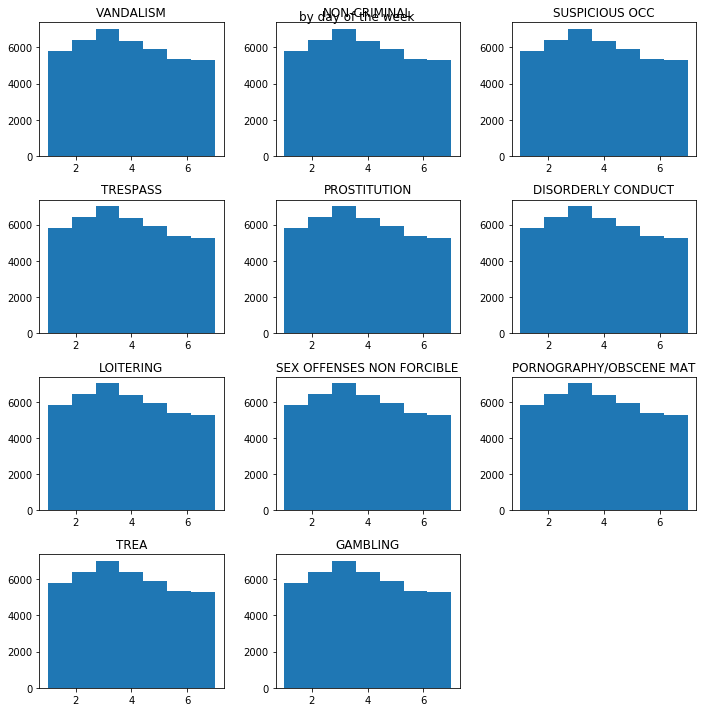

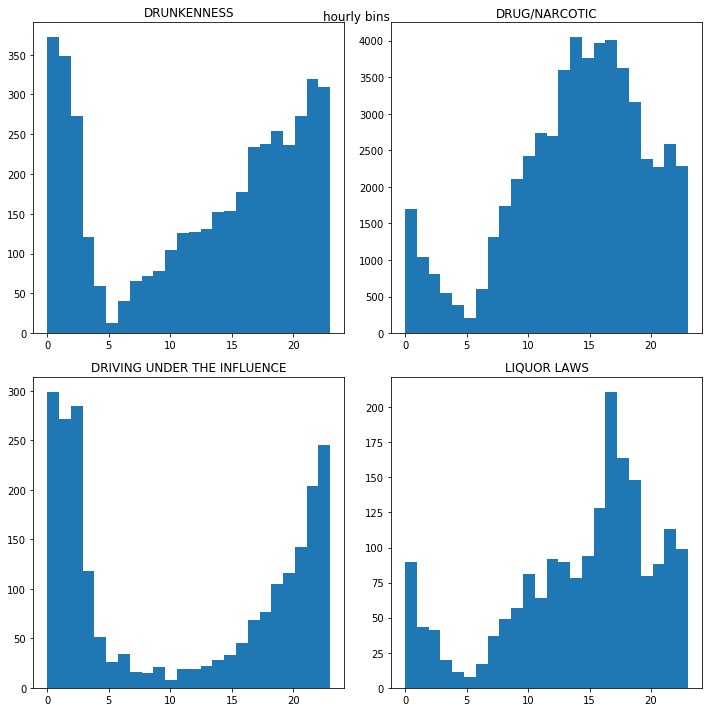

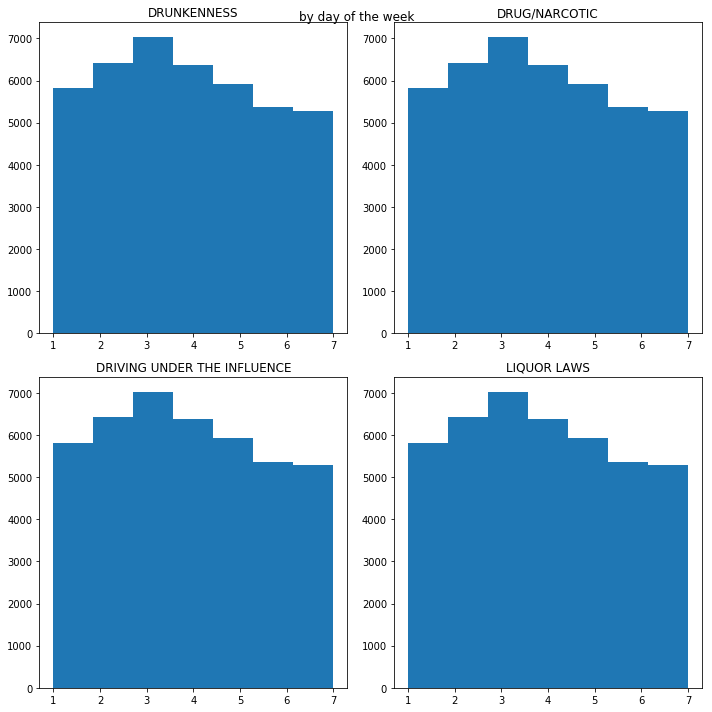

IndexError: pop index out of range

In [12]:
'''
Predicting crimes in Sa
'''
# cleaning up
del MultCounts
del MultProbs
del MultCountsShort
del MultProbsShort
del MultLogOdds

print('Any missing values?')
print('In train: ', pandas.isnull(train).values.any())
print('In test:  ', pandas.isnull(test).values.any())

'''

Taking care of the dates

'''

# split Dates into new columns Date, Year, Month, Day, DayOfYear and Hour
train['Date'] = pandas.to_datetime(train['Dates'].dt.date)
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['Day'] = train['Dates'].dt.day
train['DayOfYear'] = train['Dates'].dt.dayofyear   # the ordinal day of the year
train['Time'] = train['Dates'].dt.hour + train['Dates'].dt.minute/60
train['Hour'] = train['Dates'].dt.hour
train['Minutes'] = train['Dates'].dt.minute
del train['Dates']
test['Date'] = pandas.to_datetime(test['Dates'].dt.date)
test['Year'] = test['Dates'].dt.year
test['Month'] = test['Dates'].dt.month
test['Day'] = test['Dates'].dt.day
test['DayOfYear'] = test['Dates'].dt.dayofyear   # the ordinal day of the year
test['Time'] = test['Dates'].dt.hour + test['Dates'].dt.minute/60
test['Hour'] = test['Dates'].dt.hour
test['Minutes'] = test['Dates'].dt.minute
del test['Dates']

print(max(train['DayOfYear']))
print(min(train['DayOfYear']))
print("Any data for February 29?")
print(train[(train['Month'] == 2) & (train['Day'] == 29)])

# There are no data for February 29 in any year, i.e. leap
# years are not considered properly, yet another problem
# we won't worry about

# add column with named days of the week as number:
train.loc[train['DayOfWeek'] == 'Monday', 'DOW'] = 1
train.loc[train['DayOfWeek'] == 'Tuesday', 'DOW'] = 2
train.loc[train['DayOfWeek'] == 'Wednesday', 'DOW'] = 3
train.loc[train['DayOfWeek'] == 'Thursday', 'DOW'] = 4
train.loc[train['DayOfWeek'] == 'Friday', 'DOW'] = 5
train.loc[train['DayOfWeek'] == 'Saturday', 'DOW'] = 6
train.loc[train['DayOfWeek'] == 'Sunday', 'DOW'] = 7
test.loc[test['DayOfWeek'] == 'Monday', 'DOW'] = 1
test.loc[test['DayOfWeek'] == 'Tuesday', 'DOW'] = 2
test.loc[test['DayOfWeek'] == 'Wednesday', 'DOW'] = 3
test.loc[test['DayOfWeek'] == 'Thursday', 'DOW'] = 4
test.loc[test['DayOfWeek'] == 'Friday', 'DOW'] = 5
test.loc[test['DayOfWeek'] == 'Saturday', 'DOW'] = 6
test.loc[test['DayOfWeek'] == 'Sunday', 'DOW'] = 7



#pdfPlots = PdfPages('plots.pdf')

# number of occurrences of different crimes
crimes_rating = train['Category'].value_counts()
y_pos = numpy.arange(len(crimes_rating[0:39].keys()))

matplotlib.pyplot.figure(figsize=(10,10))
matplotlib.pyplot.barh(y_pos, crimes_rating[0:39].get_values(),  align='center', alpha=0.4, color = 'black')
matplotlib.pyplot.yticks(y_pos, map(lambda x:x.title(),crimes_rating[0:39].keys()), fontsize = 14)
matplotlib.pyplot.xlabel('Number of occurrences', fontsize = 14)
matplotlib.pyplot.title('San Francisco Crimes', fontsize = 28)
matplotlib.pyplot.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
matplotlib.pyplot.tight_layout()
#pdfPlots.savefig()
matplotlib.pyplot.show()

print ('San Francisco Crimes\n')
print ('Category\t\tNumber of occurrences') 
print (crimes_rating)

# a plot of the time of the day at which some crimes occur
larceny = train[train['Category'] == "LARCENY/THEFT"]
assault = train[train['Category'] == "ASSAULT"]
drug = train[train['Category'] == "DRUG/NARCOTIC"]
vehicle = train[train['Category'] == "VEHICLE THEFT"]
vandalism = train[train['Category'] == "VANDALISM"]
burglary = train[train['Category'] == "BURGLARY"]

with matplotlib.pyplot.style.context('fivethirtyeight'):
    ax1 = matplotlib.pyplot.subplot2grid((3, 3), (0, 0), colspan=3)
    ax1.plot(train.groupby('Hour').size(), 'ro-')
    ax1.set_title('All crimes')
    start, end = ax1.get_xlim()
    ax1.xaxis.set_ticks(numpy.arange(start, end, 1))

    ax2 = matplotlib.pyplot.subplot2grid((3, 3), (1, 0))
    ax2.plot(larceny.groupby('Hour').size(), 'o-')
    ax2.set_title('Larceny/Theft')

    ax3 = matplotlib.pyplot.subplot2grid((3, 3), (1, 1))
    ax3.plot(assault.groupby('Hour').size(), 'o-')
    ax3.set_title('Assault')

    ax4 = matplotlib.pyplot.subplot2grid((3, 3), (1, 2))
    ax4.plot(drug.groupby('Hour').size(), 'o-')
    ax4.set_title('Drug/Narcotic')

    ax5 = matplotlib.pyplot.subplot2grid((3, 3), (2, 0))
    ax5.plot(vehicle.groupby('Hour').size(), 'o-')
    ax5.set_title('Vehicle')

    ax6 = matplotlib.pyplot.subplot2grid((3, 3), (2, 1))
    ax6.plot(vandalism.groupby('Hour').size(), 'o-')
    ax6.set_title('Vandalism')

    ax7 = matplotlib.pyplot.subplot2grid((3, 3), (2, 2))
    ax7.plot(burglary.groupby('Hour').size(), 'o-')
    ax7.set_title('Burglary')

    pylab.gcf().text(0.5, 0.98,
                     'San Franciso Crime Occurence by Hour',
                     horizontalalignment='center',
                     verticalalignment='top',
                     fontsize=20)

matplotlib.pyplot.tight_layout(2)
matplotlib.pyplot.show()
#pdfPlots.savefig()

# cleaning up
del larceny
del assault
del drug
del vehicle
del vandalism
del burglary

# let's consider various subsets of crimes
# and plot their distributions by hour
# and day of the week

def plot_by_hour(category, nrow, ncol):
    fig1 = matplotlib.pyplot.figure(figsize=(10, 10))
    for i in range(1, len(category)+1):
        ax = 'ax' + str(i)
        ax = fig1.add_subplot(nrow, ncol, i)
        ax.hist(train.loc[train['Category'] == category[i - 1], 'Hour'], bins=24)
        ax.set_title(category[i - 1])
    matplotlib.pyplot.suptitle("hourly bins")
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

def plot_by_day(category, nrow, ncol):
    fig1 = matplotlib.pyplot.figure(figsize=(10, 10))
    for i in range(1, len(category)+1):
        ax = 'ax' + str(i)
        ax = fig1.add_subplot(nrow, ncol, i)
        ax.hist(train.loc[train['Category'] == otherCrimes[0], 'DOW'], bins=7)
        ax.set_title(category[i - 1])
    matplotlib.pyplot.suptitle("by day of the week")
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

otherCrimes = ['WARRANTS',
               'OTHER OFFENSES',
               'WEAPON LAWS',
               'SECONDARY CODES']

plot_by_hour(otherCrimes, 2, 2)
plot_by_day(otherCrimes, 2, 2)

familyCrimes = ['MISSING PERSON',
                'RUNAWAY',
                'FAMILY OFFENSES',
                'SUICIDE']

plot_by_hour(familyCrimes, 2, 2)
plot_by_day(familyCrimes, 2, 2)

violentCrimes = ['ASSAULT',
                 'SEX OFFENSES FORCIBLE',
                 'ARSON',
                 'KIDNAPPING']

plot_by_hour(violentCrimes, 2, 2)
plot_by_day(violentCrimes, 2, 2)

theftBurglary = ['LARCENY/THEFT',
                 'VEHICLE THEFT',
                 'ROBBERY',
                 'BURGLARY',
                 'STOLEN PROPERTY',
                 'RECOVERED VEHICLE']

plot_by_hour(theftBurglary, 3, 2)
plot_by_day(theftBurglary, 3, 2)

economicCrimes = ['FORGERY/COUNTERFEITING',
                  'FRAUD',
                  'BRIBERY',
                  'EMBEZZLEMENT',
                  'BAD CHECKS',
                  'EXTORTION']

plot_by_hour(economicCrimes, 3, 2)
plot_by_day(economicCrimes, 3, 2)

publicDisorder = ['VANDALISM',
                  'NON-CRIMINAL',
                  'SUSPICIOUS OCC',
                  'TRESPASS',
                  'PROSTITUTION',
                  'DISORDERLY CONDUCT',
                  'LOITERING',
                  'SEX OFFENSES NON FORCIBLE',
                  'PORNOGRAPHY/OBSCENE MAT',
                  'TREA',
                  'GAMBLING']

plot_by_hour(publicDisorder, 4, 3)
plot_by_day(publicDisorder, 4, 3)

drugsAlcohol = ['DRUNKENNESS',
                'DRUG/NARCOTIC',
                'DRIVING UNDER THE INFLUENCE',
                'LIQUOR LAWS']

plot_by_hour(drugsAlcohol, 2, 2)
plot_by_day(drugsAlcohol, 2, 2)

#pdfPlots.close()

# we won't need the numbered days of the week any more
del train['DOW']
del test['DOW']



In [21]:
cal = calendar()
cal.rules

[Holiday: New Years Day (month=1, day=1, observance=<function nearest_workday at 0x11485b7b8>),
 Holiday: MemorialDay (month=5, day=31, offset=<DateOffset: kwds={'weekday': MO(-1)}>),
 Holiday: July 4th (month=7, day=4, observance=<function nearest_workday at 0x11485b7b8>),
 Holiday: Labor Day (month=9, day=1, offset=<DateOffset: kwds={'weekday': MO(+1)}>),
 Holiday: Thanksgiving (month=11, day=1, offset=<DateOffset: kwds={'weekday': TH(+4)}>)]

################################
Years for which we have data: 

[2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003]
[2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003]
###################################
###################################
#############################
clean block addresses...
clean intersection addresses...
logodds munging of the addresses in train...


/Users/jawa/anaconda2/envs/eff_treat/lib/python3.6/site-packages/ipykernel/__main__.py:228: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


logodds munging of the addresses in test...


/Users/jawa/anaconda2/envs/eff_treat/lib/python3.6/site-packages/ipykernel/__main__.py:251: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


-122.51364206429
-120.5
37.7078790224135
90.0
How often are the coordinates wrong in train?
67
How often are the coordinates wrong in test?
76
['5TH OFARRELL' 'JAMESLICKFREEWAY SILVER' '5TH EDDY' '5TH ELLIS'
 'WILLIAMS YOSEMITE' 'BRENHAM WASHINGTON' 'GEARY PALMS' '19TH STCHARLES'
 '1ST BRANNAN' 'STJOSEPHS TURK' 'MONTGOMERY THEEMBARCADERONORTH'
 'DONNER FITCH' '7TH MCALLISTER' 'EUCLID PALMS' 'BEACH VANNESS'
 'LAGRANDE PERSIA' '3RD ISLAISCREEK' 'AUSTIN LARKIN' 'INGALLS JENNINGS'
 'GENEVA INTERSTATE280' 'ARGUELLO NORTHRIDGE' 'CHARLESJBRENHAM CLAY'
 'MONTEREY STELMO' 'I-280 PENNSYLVANIA' 'ALAMEDA FLORIDA'
 'CESARCHAVEZ I-280' 'BRYANT SPEAR' '4TH JAMESLICKFREEWAY'
 'GREENWICH THEEMBARCADERONORTH' 'FITCH GILMAN'
 'JOHNFKENNEDY MARTINLUTHERKINGJR' 'CESARCHAVEZ JAMESLICKFREEWAY'
 '3RD JAMESLICKFREEWAY' 'SPEAR THEEMBARCADEROSOUTH']
How often are the coordinates wrong in train?
0
How often are the coordinates wrong in test?
0
-122.51364206429
-122.36493749408001
37.7078790224135
37.8199754922970

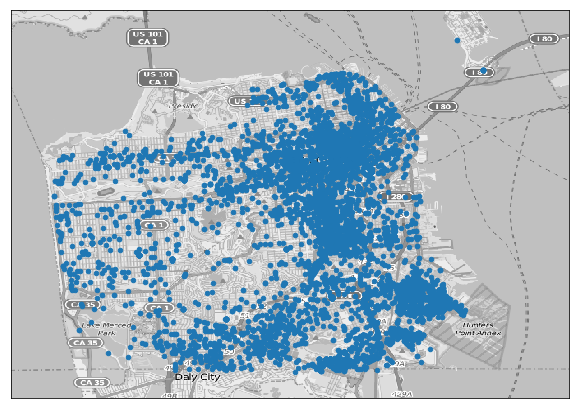

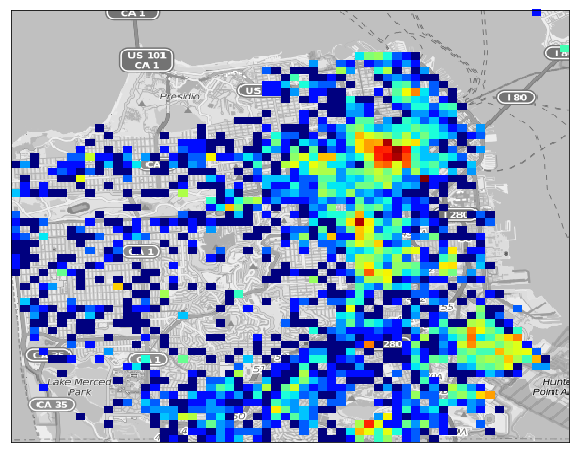

['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']
save the cleaned and engineered data to csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 95 columns):
Category         878049 non-null object
DayOfWeek        878049 non-null object
PdDistrict       878049 non-null object
X                878049 non-null float64
Y                878049 non-null float64
NumMultCrimes    878049 non-null int64
MultProbs1       878049 non-null float64
MultProbs2       878049 non-null float64
MultProbs3       878049 non-null float64
MultProbs4       878049 non-null float64
MultProbs5       878049 non-null float64
MultProbs6       878049 non-null float64
MultProbs7       878049 non-null float64
MultProbs8       878049 non-null float64
MultProbs9       878049 non-null float64
MultProbs10      878049 non-null float64
MultProbs11      878049 non-null float64
MultProbs12      878049 non-null float64
Mult

In [22]:
# Presumably, crime rates will be different on working days on the
# one hand and weekdays and holidays on the other hand.
# So we'll introduce a column WorkingDay

# Data on holidays and which businesses actually observe them are sketchy
# at best, so we'll only count the most important ones as holidays:
#  - New Year
#  - Memorial Day
#  - Independence Day
#  - Labor Day
#  - Thanksgiving
#  - Black Friday
#  - Christmas

cal = calendar()
# need to remove rules in descending order!
#cal.rules.pop(7) # remove Veterans Day
# cal.rules.pop(6) # remove Columbus Day
# cal.rules.pop(2) # remove President's Day
# cal.rules.pop(1) # remove Martin Luther King Day
# create new rule for Black Friday
USBlackFriday = Holiday('BlackFriday', month=11, day=1,
                            offset=DateOffset(weekday=FR(4)))

# create own holiday calendar based on the above rules
ownCal = HolidayCalendarFactory('OwnCalendar', cal, USBlackFriday)
#print(ownCal.rules)
cal = ownCal()
#holidays = cal.holidays(start='2003-01-01', end='2015-05-13', return_name=True) # also returns name of holiday
holidays = cal.holidays(start='2003-01-01', end='2015-05-13')
#print(holidays)

# set flag according to whether the day is a holiday, a weekend or not
train['Workingday'] = ((train['DayOfWeek'].isin(['Saturday', 'Sunday'])==False) &
                       (train['Date'].isin(holidays)==False))
test['Workingday'] = ((test['DayOfWeek'].isin(['Saturday', 'Sunday'])==False) &
                      (test['Date'].isin(holidays)==False))

# transform from True/False into 1/0
train['Workingday'] = train['Workingday'].astype(int)
test['Workingday'] = test['Workingday'].astype(int)

#print(train[(train['Year'] == 2003) & (train['Month'] == 4) & (train['Day'] == 4) & (train['Hour']<4)])


print('################################')
# names of columns
#print(list(train.columns.values))
#print(list(test.columns.values))
# data types of columns
#print(train.dtypes)
#print(test.dtypes)

print('Years for which we have data: \n')
print(train.Year.unique())
print(test.Year.unique())

#print('train.info', train.info())
#print('test.info', test.info())

print('###################################')

# checking for daylight saving Hour
# For example in 2014, DST started on March 9 at 2 am,
# i.e. there should be no Hour stamps between 2am and 3am
# Those Hourstamp do exist, however, hence DST seems not
# to be implemented in the data, one fewer complication
# to worry about
#print(train[(train['Year'] == 2003) & (train['Month'] == 4) & (train['Day'] == 6) & (train['Hour']<4)])
#print(train[(train['Year'] == 2014) & (train['Month'] == 3) & (train['Day'] == 9) & (train['Hour']<4)])

print('###################################')
# introduce a new column denoting whether it is night or not
train['Night'] = True
test['Night'] = True

train.loc[(train['Month'] ==  1) & (train['Time'] > 7.3) & (train['Time'] < 17.3), 'Night'] = False
train.loc[(train['Month'] ==  2) & (train['Time'] > 7.0) & (train['Time'] < 17.8), 'Night'] = False
train.loc[(train['Month'] ==  3) & (train['Time'] > 6.3) & (train['Time'] < 18.3), 'Night'] = False
train.loc[(train['Month'] ==  4) & (train['Time'] > 5.5) & (train['Time'] < 18.8), 'Night'] = False
train.loc[(train['Month'] ==  5) & (train['Time'] > 5.0) & (train['Time'] < 19.3), 'Night'] = False
train.loc[(train['Month'] ==  6) & (train['Time'] > 4.8) & (train['Time'] < 19.5), 'Night'] = False
train.loc[(train['Month'] ==  7) & (train['Time'] > 5.0) & (train['Time'] < 19.5), 'Night'] = False
train.loc[(train['Month'] ==  8) & (train['Time'] > 5.5) & (train['Time'] < 19.0), 'Night'] = False
train.loc[(train['Month'] ==  9) & (train['Time'] > 5.8) & (train['Time'] < 18.3), 'Night'] = False
train.loc[(train['Month'] == 10) & (train['Time'] > 6.3) & (train['Time'] < 17.5), 'Night'] = False
train.loc[(train['Month'] == 11) & (train['Time'] > 6.8) & (train['Time'] < 17.0), 'Night'] = False
train.loc[(train['Month'] == 12) & (train['Time'] > 7.3) & (train['Time'] < 16.9), 'Night'] = False
test.loc[(test['Month'] ==  1) & (test['Time'] > 7.3) & (test['Time'] < 17.3), 'Night'] = False
test.loc[(test['Month'] ==  2) & (test['Time'] > 7.0) & (test['Time'] < 17.8), 'Night'] = False
test.loc[(test['Month'] ==  3) & (test['Time'] > 6.3) & (test['Time'] < 18.3), 'Night'] = False
test.loc[(test['Month'] ==  4) & (test['Time'] > 5.5) & (test['Time'] < 18.8), 'Night'] = False
test.loc[(test['Month'] ==  5) & (test['Time'] > 5.0) & (test['Time'] < 19.3), 'Night'] = False
test.loc[(test['Month'] ==  6) & (test['Time'] > 4.8) & (test['Time'] < 19.5), 'Night'] = False
test.loc[(test['Month'] ==  7) & (test['Time'] > 5.0) & (test['Time'] < 19.5), 'Night'] = False
test.loc[(test['Month'] ==  8) & (test['Time'] > 5.5) & (test['Time'] < 19.0), 'Night'] = False
test.loc[(test['Month'] ==  9) & (test['Time'] > 5.8) & (test['Time'] < 18.3), 'Night'] = False
test.loc[(test['Month'] == 10) & (test['Time'] > 6.3) & (test['Time'] < 17.5), 'Night'] = False
test.loc[(test['Month'] == 11) & (test['Time'] > 6.8) & (test['Time'] < 17.0), 'Night'] = False
test.loc[(test['Month'] == 12) & (test['Time'] > 7.3) & (test['Time'] < 16.9), 'Night'] = False

# transform from True/False into 1/0
train['Night'] = train['Night'].astype(int)
test['Night'] = test['Night'].astype(int)

print("#############################")

#print('train.info', train.info())
#print('test.info', test.info())

# Let's have a look at the addresses

adr = train['Address'].unique()
with open("Addresses.txt", 'w') as f:
    for s in adr:
        f.write(s + '\n')

# check whether address is an intersection or not
# one column, i.e. 1 for intersection and 0 for block should suffice
train['StreetCorner'] = train['Address'].apply(lambda x: 1 if '/' in x else 0)
test['StreetCorner'] = test['Address'].apply(lambda x: 1 if '/' in x else 0)

# Clearly, there are plenty of misspellings and
# identical entries not recognizable as such,
# i.e. A ST / B ST and B ST / A ST
#
# Let's deal with that
# We'll treat intersections and blocks separately

def combine(str1, str2):
    # combine str1 and str2 ordered alphabetically
    return sorted([str1, str2], key=str.lower)[0] + ' ' + sorted([str1, str2], key=str.lower)[1]

def cleanIntersectionAddress(intAddress):
    intAddress['Street_1'] = intAddress['Address'].str.split('/').str[0].str.rstrip()
    intAddress['Street_2'] = intAddress['Address'].str.split('/').str[1].str.lstrip()
    # replace VIA * by *
    intAddress.loc[intAddress['Street_1'].str.startswith('VIA'), 'Street_1'] = \
        intAddress.loc[intAddress['Street_1'].str.startswith('VIA'), 'Street_1'].str.replace('VIA', '').str.lstrip()
    intAddress.loc[intAddress['Street_2'].str.startswith('VIA'), 'Street_2'] = \
        intAddress.loc[intAddress['Street_2'].str.startswith('VIA'), 'Street_2'].str.replace('VIA', '').str.lstrip()
    # replace AVENUE OF THE PALMS by PALMS
    intAddress.loc[intAddress['Street_1'].str.startswith('AVENUE'), 'Street_1'] = \
        intAddress.loc[intAddress['Street_1'].str.startswith('AVENUE'), 'Street_1'].str.replace('AVENUE OF THE',
                                                                                                '').str.lstrip()
    intAddress.loc[intAddress['Street_2'].str.startswith('AVENUE'), 'Street_2'] = \
        intAddress.loc[intAddress['Street_2'].str.startswith('AVENUE'), 'Street_2'].str.replace('AVENUE OF THE',
                                                                                                '').str.lstrip()
    removeList = [' AL', ' AV', ' BL', ' CR', ' CT', ' DR', ' EX', ' HWY', ' HY',
                  ' LN', ' PL', ' PZ', ' RD', ' RW', ' ST', ' STWY', ' TER',
                  ' TR', ' WAY', ' WK', ' WY', 'STNORTH']
    for key in removeList:
        intAddress.loc[intAddress['Street_1'].str.endswith(key), 'Street_1'] = \
            intAddress.loc[intAddress['Street_1'].str.endswith(key), 'Street_1'].str.replace(key, '').str.rstrip()
        intAddress.loc[intAddress['Street_2'].str.endswith(key), 'Street_2'] = \
            intAddress.loc[intAddress['Street_2'].str.endswith(key), 'Street_2'].str.replace(key, '').str.rstrip()

    # remove all whitespaces
    intAddress['Street_1'] = intAddress['Street_1'].str.replace(' ', '')
    intAddress['Street_2'] = intAddress['Street_2'].str.replace(' ', '')

    # create new address for the replacement, combine the names
    # in Street_1 and Street_2 in alphabetical ordering
    intAddress['Address'] = intAddress.apply(lambda x: combine(x['Street_1'], x['Street_2']), axis=1)
    return intAddress['Address']

def cleanBlockAddress(blockAddress):
    # remove 'Block' and 'of' from address
    mapping = [('Block', ''),
               ('of', '')
               ]
    for key, value in mapping:
        blockAddress['Address'] = blockAddress['Address'].str.replace(key, value)

    # get number from address
    blockAddress['Number'] = blockAddress['Address'].str.split().str[0]
    # get street name from address, remove leading whitespaces
    blockAddress['Street'] = blockAddress['Address'].str.split(' ', 1).str[1].str.lstrip()
    del blockAddress['Address']
    # replace VIA * by *
    blockAddress.loc[blockAddress['Street'].str.startswith('VIA'), 'Street'] = \
        blockAddress.loc[blockAddress['Street'].str.startswith('VIA'), 'Street'].str.replace('VIA', '').str.lstrip()
    # replace AVENUE OF THE PALMS by PALMS
    blockAddress.loc[blockAddress['Street'].str.startswith('AVENUE'), 'Street'] = \
        blockAddress.loc[blockAddress['Street'].str.startswith('AVENUE'), 'Street'].str.replace('AVENUE OF THE',
                                                                                                '').str.lstrip()
    removeList = [' AL', ' AV', ' BL', ' CR', ' CT', ' DR', ' EX', ' HWY', ' HY',
                  ' LN', ' PL', ' PZ', ' RD', ' RW', ' ST', ' STWY', ' TER',
                  ' TR', ' WAY', ' WK', ' WY', 'STNORTH']
    for key in removeList:
        blockAddress.loc[blockAddress['Street'].str.endswith(key), 'Street'] = \
            blockAddress.loc[blockAddress['Street'].str.endswith(key), 'Street'].str.replace(key, '').str.rstrip()

    # remove all whitespaces
    blockAddress['Street'] = blockAddress['Street'].str.replace(' ', '')
    # create new address for the replacement
    blockAddress['Address'] = blockAddress['Number'] + ' ' + blockAddress['Street']
    return blockAddress['Address']


print('clean block addresses...')
train.loc[train['StreetCorner'] == 0, 'Address'] = \
    cleanBlockAddress(pandas.DataFrame(train.loc[train['StreetCorner'] == 0, 'Address']))
test.loc[test['StreetCorner'] == 0, 'Address'] = \
    cleanBlockAddress(pandas.DataFrame(test.loc[test['StreetCorner'] == 0, 'Address']))

print('clean intersection addresses...')
train.loc[train['StreetCorner'] == 1, 'Address'] = \
    cleanIntersectionAddress(pandas.DataFrame(train.loc[train['StreetCorner'] == 1, 'Address']))
test.loc[test['StreetCorner'] == 1, 'Address'] = \
    cleanIntersectionAddress(pandas.DataFrame(test.loc[test['StreetCorner'] == 1, 'Address']))

#print('train.info', train.info())
#print('test.info', test.info())

addresses = sorted(train["Address"].unique())
categories = sorted(train["Category"].unique())
Cat_counts = train.groupby(["Category"]).size()
Addr_Cat_counts = train.groupby(["Address","Category"]).size()
Addr_counts = train.groupby(["Address"]).size()

print('logodds munging of the addresses in train...')
logodds = {}
logoddsPA = {}
MIN_CAT_COUNTS = 5
default_logodds = numpy.log(Cat_counts/len(train))-numpy.log(1.0-Cat_counts/len(train))
for addr in addresses:
    PA = Addr_counts[addr]/len(train)
    logoddsPA[addr] = numpy.log(PA)-numpy.log(1.-PA)
    logodds[addr] = deepcopy(default_logodds)
    for cat in Addr_Cat_counts[addr].keys():
        if (Addr_Cat_counts[addr][cat]>MIN_CAT_COUNTS) and Addr_Cat_counts[addr][cat]<Addr_counts[addr]:
            AC = Addr_Cat_counts[addr][cat]/Addr_counts[addr]
            logodds[addr][categories.index(cat)] = numpy.log(AC)-numpy.log(1.0-AC)
    logodds[addr] = pandas.Series(logodds[addr])
    logodds[addr].index = range(len(categories))

addressLogodds = train["Address"].apply(lambda x: logodds[x])
addressLogodds.columns = ["logodds"+str(x) for x in range(len(addressLogodds.columns))]

train = train.join(addressLogodds.ix[:,:])

train['LogoddsPA'] = train["Address"].apply(lambda x: logoddsPA[x])

print('logodds munging of the addresses in test...')

new_addresses=sorted(test["Address"].unique())
new_Addr_counts=test.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_Addr_counts[addr]/float(len(test)+len(train))
    logoddsPA[addr]=numpy.log(PA)-numpy.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(Addr_counts[addr]+new_Addr_counts[addr])/float(len(test)+len(train))
    logoddsPA[addr]=numpy.log(PA)-numpy.log(1.-PA)

addressLogodds = test["Address"].apply(lambda x: logodds[x])
addressLogodds.columns=["logodds"+str(x) for x in range(len(addressLogodds.columns))]

test = test.join(addressLogodds.ix[:,:])

test['LogoddsPA'] = test["Address"].apply(lambda x: logoddsPA[x])

#print('train.info', train.info())
#print('test.info', test.info())

# some map plots

#latitude and longitude of map data
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

# which latitudes and longitudes do we have in the data?
print(min(train['X']))
print(max(train['X']))
print(min(train['Y']))
print(max(train['Y']))

# clearly some values are wrong

print('How often are the coordinates wrong in train?')
print(train.loc[train['Y'] > 38].count()['Y'])
print('How often are the coordinates wrong in test?')
print(test.loc[test['Y'] > 38].count()['Y'])

wrongLatAdr = train.loc[train['Y'] > 38, 'Address']
print(wrongLatAdr.unique())

# Fortunately, there are comparatively few instances of wrong coordinates
# for simplicity we'll just impute the values with the median for the
# corresponding Police district

# medians of X and Y by police district
listOfPrecincts = train['PdDistrict'].unique()
precinctX = (train.groupby('PdDistrict'))['X'].median()
precinctY = (train.groupby('PdDistrict'))['Y'].median()

# impute wrong values with the medians
for i in range(len(listOfPrecincts)) :
    train.loc[ (train['Y'] > 38) & (train['PdDistrict'] == listOfPrecincts[i]), 'X'] = \
        precinctX[listOfPrecincts[i]]
    train.loc[(train['Y'] > 38) & (train['PdDistrict'] == listOfPrecincts[i]), 'Y'] = \
        precinctY[listOfPrecincts[i]]
    test.loc[ (test['Y'] > 38) & (test['PdDistrict'] == listOfPrecincts[i]), 'X'] = \
        precinctX[listOfPrecincts[i]]
    test.loc[(test['Y'] > 38) & (test['PdDistrict'] == listOfPrecincts[i]), 'Y'] = \
        precinctY[listOfPrecincts[i]]

# check that replacement worked
print('How often are the coordinates wrong in train?')
print(train.loc[train['Y'] > 38].count()['Y'])
print('How often are the coordinates wrong in test?')
print(test.loc[test['Y'] > 38].count()['Y'])

# which latitudes and longitudes do we have in the data?
print(min(train['X']))
print(max(train['X']))
print(min(train['Y']))
print(max(train['Y']))

#latitude and longitude of map data
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

mapdata = numpy.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")

# scatter plot
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat_box, cmap=matplotlib.pyplot.get_cmap('gray'))
ax1.scatter(train.loc[train['Category'] == otherCrimes[2]].X,train.loc[train['Category'] == otherCrimes[2]].Y,s=20)
ax1.get_xaxis().set_ticks([])
ax1.get_xaxis().set_ticklabels([])
ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_ticklabels([])
matplotlib.pyplot.show()

# 2d histogram
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat_box, cmap=matplotlib.pyplot.get_cmap('gray'))
ax1.hist2d(train.loc[train['Category'] == otherCrimes[2]].X,train.loc[train['Category'] == otherCrimes[2]].Y,
           bins=60, norm=LogNorm(), cmap=matplotlib.pyplot.cm.jet)
ax1.get_xaxis().set_ticks([])
ax1.get_xaxis().set_ticklabels([])
ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_ticklabels([])
matplotlib.pyplot.show()

print(train['PdDistrict'].unique())

# drop the predictors we no longer need
del train['Descript']
del train['Resolution']
del train['Address']
del train['Date']

del test['Address']
del test['Date']

print('save the cleaned and engineered data to csv')
train.to_csv('train_new.csv', index=False)
test.to_csv('test_new.csv', index=False)

print('train.info', train.info())
print('test.info', test.info())


